# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

The original notebook had the imports and set-up for plotting scattered around the notebook, but since there's so many different parts to work on it made it difficult to hunt them all down whenever I restarted the notebook so I've moved them here, but left the original imports in place (or nearly so).

## Imports

In [1]:
# python
from datetime import datetime
from functools import partial
from pathlib import Path
import warnings

# from pypi
from PIL import Image, ImageFile
from torchvision import datasets
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)
import cv2
import face_recognition
import matplotlib.image as matplotlib_image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizer
import torchvision.models as models
import torchvision.transforms as transforms

I tend to use the full names, but the included code uses the common practice (just not mine) of shortening `numpy` and `pyplot` so I'm going to alias them to cut down on the `NameError`s.

In [2]:
pyplot = plt
numpy = np

### Set Up the Plotting

In [3]:
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
seaborn.set(style="whitegrid",
            rc={"axes.grid": False,
                "font.family": ["sans-serif"],
                "font.sans-serif": ["Open Sans", "Latin Modern Sans", "Lato"],
                "figure.figsize": (8, 6)},
            font_scale=1)

## Constants

In [4]:
INCEPTION_IMAGE_SIZE = 299
SCRATCH_IMAGE_SIZE = INCEPTION_IMAGE_SIZE
VGG_IMAGE_SIZE = 224

MEANS = [0.485, 0.456, 0.406]
DEVIATIONS = [0.229, 0.224, 0.225]
DOG_LOWER, DOG_UPPER = 150, 260

Load filenames for human and dog images.

In [5]:
ROOT_PATH = Path("~/datasets/dog-breed-classification/").expanduser()
HUMAN_PATH = ROOT_PATH.joinpath("lfw")
DOG_PATH = ROOT_PATH.joinpath("dogImages")
MODEL_PATH = Path("~/models/dog-breed-classification").expanduser()

assert HUMAN_PATH.is_dir()
assert DOG_PATH.is_dir()
assert MODEL_PATH.is_dir()

The `MODELS` is a place to store things that have been moved to the GPU so I can off-load them if needed.

In [6]:
MODELS = []

## Check CUDA

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using {}".format(device))

Using cuda


## Handle Truncated Images

In [8]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [9]:
human_files = np.array(list(HUMAN_PATH.glob("*/*")))
dog_files = np.array(list(DOG_PATH.glob("*/*/*")))

assert len(human_files) > 0
assert len(dog_files) > 0

# print number of images in each dataset
print('There are {:,} total human images.'.format(len(human_files)))
print('There are {:,} total dog images.'.format(len(dog_files)))

There are 13,233 total human images.
There are 8,351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


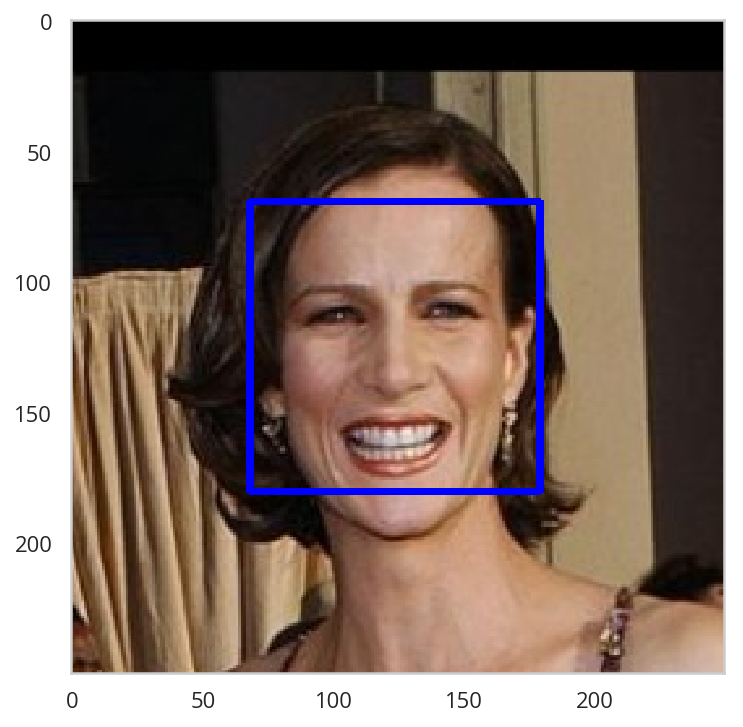

In [19]:
import cv2
import warnings
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)
import matplotlib.pyplot as plt

# extract pre-trained face detector
haar_path = ROOT_PATH.joinpath('haarcascades/haarcascade_frontalface_alt.xml')
assert haar_path.is_file()
face_cascade = cv2.CascadeClassifier(str(haar_path))

# load color (BGR) image
img = cv2.imread(str(human_files[0]))
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [10]:
def face_detector(img_path):
    """"returns True if face is detected in image stored at img_path"""
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
See output below.

In [20]:
from tqdm import tqdm
from tabulate import tabulate

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

In [12]:
set([" ".join(filename.name.split("_")[:-1]) for filename in dog_files_short])

{'Cavalier king charles spaniel',
 'Chesapeake bay retriever',
 'Glen of imaal terrier'}

I'm going to re-do this again with `dlib` so I'll make a function to answer the question of percentages and add an f1 score to make it a little easier to compare them.

In [13]:
def species_scorer(predictor: callable,
                   true_species: list,
                   false_species: list,
                   labels: list) -> list:
    """Emit a score-table for the predictor

    Args:
     predictor: callable that returns True if it detects the expected species
     true_species: list of images that should be matched by predictor
     false_species: list of images that shouldn't be matched by predictor
     labels: column labels for the table

    Returns:
     false-positive indices
    """
    misses = [predictor(str(image)) for image in false_species]
    false_positives = sum(misses)
    true_positives = sum([predictor(str(image)) for image in true_species])
    false_negatives = len(true_species) - true_positives
    others = len(false_species)
    expected = len(true_species)
    values = ("{:.2f}%".format(100 * true_positives/expected),
            "{:.2f}%".format(100 * false_positives/others),
              "{:.2f}".format((2 * true_positives)/(2 * true_positives
                                                    + false_positives
                                                    + false_negatives)))
    table = zip(labels, values)
    print(tabulate(table, tablefmt="github", headers=["Metric", "Value"]))
    return misses

In [21]:
face_scorer = partial(species_scorer,
                      true_species=human_files_short,
                      false_species=dog_files_short,
                      labels=("First 100 images in `human_files` detected with a face",
                              "First 100 images in `dog_files` detected with a face",
                              "F1"))

In [22]:
open_cv_false_positives = face_scorer(face_detector)

Metric                                                  Value
------------------------------------------------------  -------
First 100 images in `human_files` detected with a face  99.00%
First 100 images in `dog_files` detected with a face    9.00%
F1                                                      0.95


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

## DLIB with `face_recognition`

This face detector uses [=face_recognition=](https://github.com/ageitgey/face_recognition), a python interface to [dlib's](http://dlib.net/) facial recognition code.

### Testing It with An Image

I created the `detect_faces` and `add_bounding_boxes` functions so that I can re-use `detect_faces` later for the dlib version of the `face_detector` function.

In [23]:
def detect_faces(image_path: str) -> numpy.ndarray:
    """Finds the locations of faces
    
    Args:
     image_path: path to the image
        
    Returns:
     array of bounding box coordinates for the face(s)
    """
    image = face_recognition.load_image_file(str(image_path))
    return face_recognition.face_locations(image)

In [24]:
def add_bounding_boxes(image_path: str,
                       axe: matplotlib.axes.Axes) -> None:
    """Adds patches to the current matplotlib figure
    
    Args:
     image_path: path to the image file
     axe: axes to add the rectangle to
    """
    for (top, right, bottom, left) in detect_faces(image_path):
        width = right - left
        height = top - bottom
        rectangle = matplotlib.patches.Rectangle((top, right), width, height,
                                      fill=False)
        axe.add_patch(rectangle)
    return    

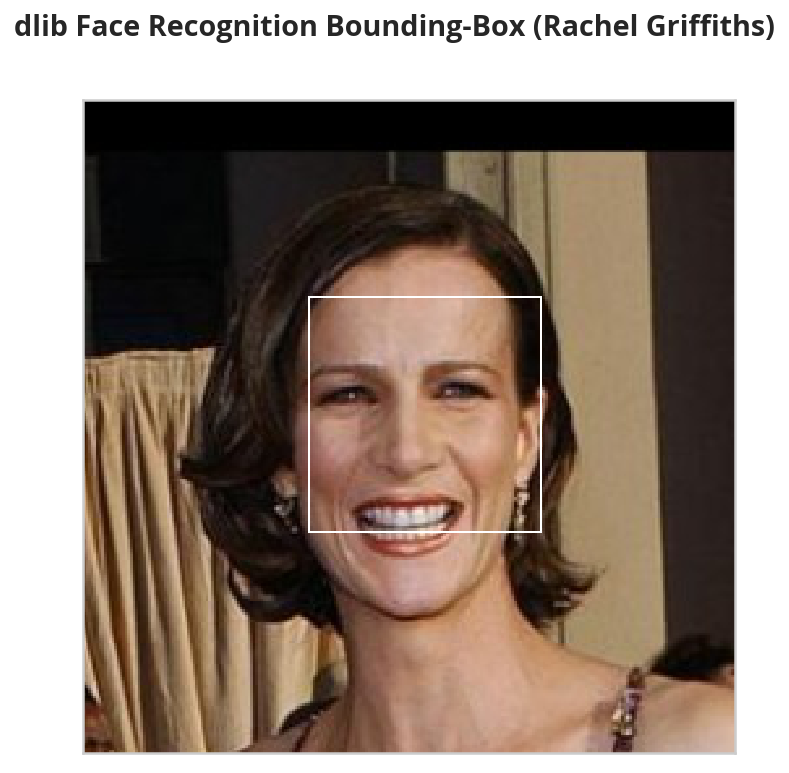

In [25]:
figure, axe = pyplot.subplots()
human = human_files[0]
name = " ".join(human.name.split("_")[:-1])
image = matplotlib.image.imread(human)
figure.suptitle("dlib Face Recognition Bounding-Box ({})".format(name),
                weight='bold')
add_bounding_boxes(human, axe)
axe.tick_params(dict(axis="both",
                     which="both",
                     bottom=False,
                     top=False))
axe.get_xaxis().set_ticks([])
axe.get_yaxis().set_ticks([])
        
plot = axe.imshow(image)

### Test the performance

In [26]:
def has_face(image_path: str) -> bool:
    """Checks if there is at least one face in the image

    Args:
     image_path: path to the image file

    Returns:
     True if there's at least one face in the image
    """
    return len(detect_faces(image_path)) > 0

In [27]:
dlib_false_positives = face_scorer(has_face)

Metric                                                  Value
------------------------------------------------------  -------
First 100 images in `human_files` detected with a face  100.00%
First 100 images in `dog_files` detected with a face    17.00%
F1                                                      0.92


The DLIB version did slightly better in recognizing the humans as humans, but it also had more false positives so it did about the same overall. Although I didn't include the time the `dlib` version is about four times slower than the `OpenCV` version, so might be better in a real-time environment, on the other hand the `dlib` version is much simpler to use and so might be better if speed isn't a factor or recall is more important than precision.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [28]:
import torch
import torchvision.models as models

In [29]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

In [30]:
# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    MODELS.append(VGG16)

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

### Transforms

The VGG model expects a 244x244 image ([Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)) and according to the [pytorch documentation](https://pytorch.org/docs/stable/torchvision/models.html) all the pre-trained models have means `[0.485, 0.456, 0.406]` and standard deviations `[0.229, 0.224, 0.225]` so the images need to be transformed accordingly. The `MEANS` and `DEVIATIONS` lists are defined in the constants section at the top of the document along with the `VGG_IMAGE_SIZE`.

In [31]:
vgg_transform = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(VGG_IMAGE_SIZE),
                                    transforms.ToTensor(),
                                    transforms.Normalize(MEANS,
                                                         DEVIATIONS)])

Since I'm going to use the Inception-v3 network later on I'm going to create a generic function first and then use it to build separate predictor functions. 

In [32]:
def model_predict(image_path: str, model: nn.Module,
                  transform: transforms.Compose) -> int:
    """Predicts the class of item in image

    Args:
     image_path: path to the image to check
     model: model to make the prediction
     transform: callable to convert the image to a tensor

    Returns:
     index corresponding to the model's prediction
    """
    image = Image.open(str(image_path))
    image = transform(image).unsqueeze(0).to(device)
    output = model(image)
    probabilities = torch.exp(output)
    _, top_class = probabilities.topk(1, dim=1)
    return top_class.item()    

In [33]:
VGG16_predict = partial(model_predict, model=VGG16, transform=vgg_transform)

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [35]:
def dog_detector(img_path: str, predictor: callable=VGG16_predict) -> bool:
    """Predicts if the image is a dog

    Args:
     img_path: path to image file
     predictor: callable that maps the image to an ID
    
    Returns:
     is-dog: True if the image contains a dog
    """
    return DOG_LOWER < predictor(img_path) < DOG_UPPER

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

In [36]:
dog_scorer = partial(species_scorer,
                     true_species=dog_files_short,
                     false_species=human_files_short,
                     labels=("Images in `dog_files_short` with a detected dog",
                             "Images in `human_files_short with a detected dog", "F1"))

In [37]:
false_dogs = dog_scorer(dog_detector)

Metric                                            Value
------------------------------------------------  -------
Images in `dog_files_short` with a detected dog   100.00%
Images in `human_files_short with a detected dog  1.00%
F1                                                1.00


The VGG model didn't miss any dogs but it misclassified 1% of the humans as dogs.

We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

## Inception Dog Detector

In [38]:
inception = models.inception_v3(pretrained=True)
inception.to(device)
MODELS.append(inception)
inception.eval()
pass # this is to prevent the output from dumping into the notebook

I couldn't find anyplace where pytorch documents it, but if you look at [the source code](https://pytorch.org/docs/stable/_modules/torchvision/models/inception.html#inception_v3) they have a comment in the `forward` method indicating that the image needs to be *299x299x3* so they need to be transformed to a different size from the VGG images. `INCEPTION_IMAGE_SIZE` is set to `299# at the top of this document since this is shared with code that comes in a later section.

In [39]:
inception_transforms = transforms.Compose([transforms.Resize(INCEPTION_IMAGE_SIZE),
                                           transforms.ToTensor(),
                                           transforms.Normalize(MEANS,
                                                                DEVIATIONS)])

In [40]:
inception_predicts = partial(model_predict, model=inception, transform=inception_transforms)

In [41]:
inception_dog_detector = partial(dog_detector, predictor=inception_predicts)

In [42]:
dlib_false_dogs = dog_scorer(inception_dog_detector)

Metric                                            Value
------------------------------------------------  -------
Images in `dog_files_short` with a detected dog   100.00%
Images in `human_files_short with a detected dog  0.00%
F1                                                1.00


The inception model seems to do better than the VGG model did, but the difference was slight and we're only looking at three classes, so they are probably comparable overall.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

The `SCRATCH_IMAGE_SIZE`, `MEANS`, and `DEVIATIONS` variables are defined in the constants section at the top of the notebook.

In [9]:
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(SCRATCH_IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEANS,
                         DEVIATIONS)])

test_transform = transforms.Compose([transforms.Resize(350),
                                     transforms.CenterCrop(SCRATCH_IMAGE_SIZE),
                                     transforms.ToTensor(),
                                     transforms.Normalize(MEANS,
                                                          DEVIATIONS)])

In [10]:
dog_training_path = DOG_PATH.joinpath("train")
dog_validation_path = DOG_PATH.joinpath("valid")
dog_testing_path = DOG_PATH.joinpath("test")

In [11]:
training = datasets.ImageFolder(root=str(dog_training_path),
                                transform=train_transform)
validation = datasets.ImageFolder(root=str(dog_validation_path),
                                  transform=test_transform)
testing = datasets.ImageFolder(root=str(dog_testing_path),
                               transform=test_transform)

In [12]:
BATCH_SIZE = 32
WORKERS = 0

train_batches = torch.utils.data.DataLoader(training, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=WORKERS)
validation_batches = torch.utils.data.DataLoader(
    validation, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
test_batches = torch.utils.data.DataLoader(
    testing, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)

loaders_scratch = dict(train=train_batches,
                       validation=validation_batches,
                       test=test_batches)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:
- The training images are resized by cropping them, while the testing images are resized by scaling then cropping them. The size I chose for the images was 299 pixels so that I can reuse them with an Inception V3 network in the next section.

- The training was augmented using rotation, cropping, and horizontal flipping.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [13]:
BREEDS = len(training.classes)
print("There are {} breeds.".format(BREEDS))

There are 133 breeds.


In [14]:
LAYER_ONE_IN = 3
LAYER_ONE_OUT = 16
LAYER_TWO_OUT = LAYER_ONE_OUT * 2
LAYER_THREE_OUT = LAYER_TWO_OUT * 2
FLATTEN_TO = (SCRATCH_IMAGE_SIZE//8)**2 * LAYER_THREE_OUT
FULLY_CONNECTED_OUT = int(str(FLATTEN_TO)[:3])//100 * 100
KERNEL = 3
PADDING = 1

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(LAYER_ONE_IN, LAYER_ONE_OUT,
                               KERNEL, padding=PADDING)
        self.conv2 = nn.Conv2d(LAYER_ONE_OUT, LAYER_TWO_OUT,
                               KERNEL, padding=PADDING)
        self.conv3 = nn.Conv2d(LAYER_TWO_OUT, LAYER_THREE_OUT,
                               KERNEL, padding=PADDING)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer
        self.fc1 = nn.Linear(FLATTEN_TO, FULLY_CONNECTED_OUT)
        self.fc2 = nn.Linear(FULLY_CONNECTED_OUT, BREEDS)
        # dropout layer
        self.dropout = nn.Dropout(0.25)
        return
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, FLATTEN_TO)
        x = self.dropout(x)

        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)
#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    MODELS.append(model_scratch)

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

It was largely trial and error, copying what we did in the CIFAR problem. I chose (somewhat arbitrarily) three convolutional layers, since two layers didn't seem to do very well. Each convolutional layer doubles the depth while halving the height and width (using MaxPool).

I then flattened the layer to transition from the convolutional layers to the fully-connected layers. I added a fully-connected layer which has 500 outputs - a rough rounding of the number of input weights of the flattened layer down to the nearest 100th. There wasn't any magic to the number, I just wanted a transition from the large flattened layer to the final output layer and when I was experimenting with larger values I was running out of memory and since this isn't the intended final model I tried to keep it modest.

To reduce the likelihood of overfitting I applied dropout to the activation layers (except the final one). Finally, at each of the layers (except the final output layer) I applied ReLU activation to make the model non-linear.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [17]:
import torch.optim as optimizer

criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optimizer.SGD(model_scratch.parameters(),
                                  lr=0.001,
                                  momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [18]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path,
          print_function: callable=print,
          is_inception: bool=False):
    """Trains the model

    Args:
     n_epochs: the number of times to repeat training
     loaders: dict of data batch-loaders
     model: the model to train
     optimizer: the gradient descent object
     criterion: The object to calculate the loss
     use_cuda: boolean to decide whether to move the data to the GPU
     save_path: path to file to save best model to
     print_function: something to pass output to
     is_inception: if True, expect a tuple of tensors as the model output
    """
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    # check the keys are right so you don't waste an entire epoch to find out
    training_batches = loaders["train"]
    validation_batches = loaders["validation"]
    started = datetime.now()
    print_function("Training Started: {}".format(started))
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        epoch_started = datetime.now()
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for data, target in training_batches:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            if is_inception:
                output, _ = model(data)
            else:
                output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
        train_loss /= len(training_batches.dataset)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in validation_batches:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
        valid_loss /= len(validation_batches.dataset)
        print_function('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}\tElapsed: {}'.format(
            epoch,                     
            train_loss,
            valid_loss,
            datetime.now() - epoch_started,
            ))
        
        if valid_loss < valid_loss_min:
            print_function(
                ("Validation loss decreased ({:.6f} --> {:.6f}). "
                 "Saving model ...").format(
                     valid_loss_min,
                     valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    ended = datetime.now()
    print_function("Training Ended: {}".format(ended))
    print_function("Total Training Time: {}".format(ended - started))            
    return model

### Tee

I found out the hard way that Jupyter loses the ability to re-connect to a running cell if you close and re-open the tab, so if you do close it you will have lost all your output. This is something to make sure it gets saved to a file.

In [19]:
class Tee:
    """Save the input to a file and print it

    Args:
     log_name: name to give the log    
     directory_path: path to the directory for the file
    """
    def __init__(self, log_name: str, 
                 directory_name: str="~/logs/dog-breed-classifier") -> None:
        self.directory_name = directory_name
        self.log_name = log_name
        self._path = None
        self._log = None
        return

    @property
    def path(self) -> Path:
        """path to the log-file"""
        if self._path is None:
            self._path = Path(self.directory_name).expanduser()
            assert self._path.is_dir()
            self._path = self._path.joinpath(self.log_name)
        return self._path

    @property
    def log(self):
        """File object to write log to"""
        if self._log is None:
            self._log = self.path.open("w", buffering=1)
        return self._log

    def __call__(self, line: str) -> None:
        """Writes to the file and stdout

        Args:
         line: text to emit
        """
        self.log.write("{}\n".format(line))
        print(line)
        return

## Train the Model

In [20]:
scratch_path = MODEL_PATH.joinpath("model_scratch.pt")
scratch_log = Tee(log_name="scratch_train.log")

In [21]:
EPOCHS = 100

In [22]:
model_scratch = train(EPOCHS, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, scratch_path, print_function=scratch_log)

Training Started: 2019-01-07 00:17:48.769216
Epoch: 1 	Training Loss: 4.877051 	Validation Loss: 4.841412	Elapsed: 0:03:13.834452
Validation loss decreased (inf --> 4.841412). Saving model ...
Epoch: 2 	Training Loss: 4.820985 	Validation Loss: 4.747336	Elapsed: 0:03:01.535938
Validation loss decreased (4.841412 --> 4.747336). Saving model ...
Epoch: 3 	Training Loss: 4.767189 	Validation Loss: 4.684055	Elapsed: 0:03:01.574621
Validation loss decreased (4.747336 --> 4.684055). Saving model ...
Epoch: 4 	Training Loss: 4.728553 	Validation Loss: 4.607475	Elapsed: 0:03:02.878120
Validation loss decreased (4.684055 --> 4.607475). Saving model ...
Epoch: 5 	Training Loss: 4.643230 	Validation Loss: 4.515298	Elapsed: 0:03:01.719175
Validation loss decreased (4.607475 --> 4.515298). Saving model ...
Epoch: 6 	Training Loss: 4.601643 	Validation Loss: 4.451782	Elapsed: 0:03:02.711892
Validation loss decreased (4.515298 --> 4.451782). Saving model ...
Epoch: 7 	Training Loss: 4.563049 	Validat

Epoch: 67 	Training Loss: 3.248309 	Validation Loss: 3.700498	Elapsed: 0:03:02.847392
Epoch: 68 	Training Loss: 3.186689 	Validation Loss: 3.672294	Elapsed: 0:03:04.354137
Epoch: 69 	Training Loss: 3.148231 	Validation Loss: 3.709312	Elapsed: 0:03:05.193586
Epoch: 70 	Training Loss: 3.167838 	Validation Loss: 3.735657	Elapsed: 0:03:04.797756
Epoch: 71 	Training Loss: 3.154821 	Validation Loss: 3.683042	Elapsed: 0:03:07.263391
Epoch: 72 	Training Loss: 3.151534 	Validation Loss: 3.803930	Elapsed: 0:03:02.779610
Epoch: 73 	Training Loss: 3.157296 	Validation Loss: 3.690141	Elapsed: 0:03:05.410248
Epoch: 74 	Training Loss: 3.101250 	Validation Loss: 3.771072	Elapsed: 0:03:03.327209
Epoch: 75 	Training Loss: 3.052344 	Validation Loss: 3.676567	Elapsed: 0:03:01.068909
Epoch: 76 	Training Loss: 3.043009 	Validation Loss: 3.728986	Elapsed: 0:03:01.663287
Epoch: 77 	Training Loss: 3.035244 	Validation Loss: 3.787941	Elapsed: 0:03:02.757887
Epoch: 78 	Training Loss: 3.024287 	Validation Loss: 3

## load the model that got the best validation accuracy

In [23]:
model_scratch.load_state_dict(torch.load(scratch_path))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [24]:
def test(loaders, model, criterion, use_cuda, print_function=print):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print_function('Test Loss: {:.6f}\n'.format(test_loss))

    print_function('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [25]:
scratch_test_log = Tee("scratch_test.log")

In [ ]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda, print_function=scratch_test_log)

Test Loss: 3.611238


Test Accuracy: 17% (149/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
 loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

#### The Transfer Model

In [ ]:
model_transfer = models.inception_v3(pretrained=True)
for parameter in model_transfer.parameters():
    parameter.requires_grad = False
classifier_inputs = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(in_features=classifier_inputs,
                              out_features=BREEDS,
                              bias=True)
model_transfer.to(device)
MODELS.append(model_transfer)

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I looked at the [source code](https://pytorch.org/docs/stable/_modules/torchvision/models/inception.html#inception_v3) and the string representation of the model and saw that the classification was being done by a single fully-connected (Linear) layer with 2,048 inputs and 1,000 outputs. Since we only have 133 outputs I replaced their final layer (`model.fc`) with one that had the same number of inputs but only 133 outputs.

I chose the Inception V3 network because, like the VGG 16 model, it was trained on the ImageNet data-set and works to detect features in images but, as noted in [Rethinking the Inception Architecture for Computer Vision](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html), the Inception model requires fewer computational resources than the VGG model does, which I thought was an attractive feature. The Inception model does introduce a problem in that it uses an auxiliary classifier during training so the training function has to be modified to handle this (the output returns a tuple of tensors), but this seemed minor.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [ ]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optimizer.SGD(
    model_transfer.parameters(),
    lr=0.001,
    momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
transfer_model_path = MODEL_PATH.joinpath("model_transfer.pt")
transfer_log = Tee(log_name="transfer_train.log")

In [ ]:
EPOCHS = 100

In [ ]:
# train the model
model_transfer = train(EPOCHS,
                       loaders=loaders_transfer,
                       model=model_transfer,
                       optimizer=optimizer_transfer,
                       criterion=criterion_transfer,
                       use_cuda=use_cuda,
                       save_path=transfer_model_path,
                       print_function=transfer_log,
                       is_inception=True)

Training Started: 2019-01-07 05:25:10.303990
Epoch: 1 	Training Loss: 4.699307 	Validation Loss: 4.270935	Elapsed: 0:03:18.031065
Validation loss decreased (inf --> 4.270935). Saving model ...
Epoch: 2 	Training Loss: 4.181660 	Validation Loss: 3.670290	Elapsed: 0:03:17.966246
Validation loss decreased (4.270935 --> 3.670290). Saving model ...
Epoch: 3 	Training Loss: 3.735970 	Validation Loss: 3.142542	Elapsed: 0:03:17.943660
Validation loss decreased (3.670290 --> 3.142542). Saving model ...
Epoch: 4 	Training Loss: 3.343428 	Validation Loss: 2.698115	Elapsed: 0:03:18.696943
Validation loss decreased (3.142542 --> 2.698115). Saving model ...
Epoch: 5 	Training Loss: 2.995878 	Validation Loss: 2.334530	Elapsed: 0:03:19.205373
Validation loss decreased (2.698115 --> 2.334530). Saving model ...
Epoch: 6 	Training Loss: 2.723056 	Validation Loss: 2.033339	Elapsed: 0:03:19.099028
Validation loss decreased (2.334530 --> 2.033339). Saving model ...
Epoch: 7 	Training Loss: 2.518057 	Validat

In [ ]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load(transfer_model_path))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
transfer_test_log = Tee("transfer_test.log")

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda, print_function=transfer_test_log)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [ ]:
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path: str) -> str:
    """Predicts the dog-breed of what's in the image

    Args:
     img_path: path to the image to search

    Returns:
     the name of the dog-breed
    "
    # load the image
    image = Image.open(image_path)

    # convert the image to a tensor
    tensor = test_transform(image)

    # add a batch number
    tensor = tensor.unsqueeze_(0)

    # put on the GPU or CPU
    tensor = tensor.to(device)

    # make it a variable
    x = torch.autograd.Variable(tensor)

    # make the prediction
    output = model(x)
    return class_names[output.data.cpu().numpy().argmax()]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

#### Re-Done Code

I originally wrote my implementation using classes, because I kept getting errors related to the fact that jupyter lets you run cells out of order so I wanted them defined as a group (and because I find it easier to work this way once there is this much code). So I broke the parts up to answer the questions but am including them in this section to make my final solution work. Everything until the **Dog Breed Classifier** section was already implemented in the sections above using functions and global variables instead of class methods, only the **Dog Breed Classification** section and below has new implementations.

In [ ]:
class Transformer:
    """Builds the image transformers

    Args:
     means: list of means for each channel
     deviations: list of standard deviations for each channel
     image_size: size to crop the image to
    """
    def __init__(self,
                 means: list=MEANS,
                 deviations: list=DEVIATIONS,
                 image_size: int=INCEPTION_IMAGE_SIZE) -> None:
        self.means = means
        self.deviations = deviations
        self.image_size = image_size
        self._training = None
        self._testing = None
        return

    @property
    def training(self) -> transforms.Compose:
        """The image transformers for the training"""
        if self._training is None:
            self._training = transforms.Compose([
                transforms.RandomRotation(30),
                transforms.RandomResizedCrop(self.image_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(self.means,
                                     self.deviations)])
        return self._training

    @property
    def testing(self) -> transforms.Compose:
        """Image transforms for the testing"""
        if self._testing is None:
            self._testing = transforms.Compose(
                [transforms.Resize(350),
                 transforms.CenterCrop(self.image_size),
                 transforms.ToTensor(),
                 transforms.Normalize(self.means,
                                      self.deviations)])
        return self._testing

In [ ]:
class DogDetector:
    """Detects dogs

    Args:
     model_definition: definition for the model
     device: where to run the model (CPU or CUDA)
     image_size: what to resize the file to (depends on the model-definition)
     means: mean for each channel
     deviations: standard deviation for each channel
     dog_lower_bound: index below where dogs start
     dog_upper_bound: index above where dogs end
    """
    def __init__(self,
                 model_definition: nn.Module=models.inception_v3,
                 image_size: int=INCEPTION_IMAGE_SIZE,
                 means: list=MEANS,
                 deviations: list=DEVIATIONS,
                 dog_lower_bound: int=DOG_LOWER,
                 dog_upper_bound: int=DOG_UPPER,
                 device: torch.device=None) -> None:
        self.model_definition = model_definition
        self.image_size = image_size
        self.means = means
        self.deviations = deviations
        self.dog_lower_bound = dog_lower_bound
        self.dog_upper_bound = dog_upper_bound
        self._device = device
        self._model = None
        self._transformer = None
        return

    @property
    def device(self) -> torch.device:
        """The device to add the model to"""
        if self._device is None:
            self._device = torch.device("cuda"
                                        if torch.cuda.is_available()
                                        else "cpu")
        return self._device

    @property
    def model(self) -> nn.Module:
        """Build the model"""
        if self._model is None:
            self._model = self.model_definition(pretrained=True)
            self._model.to(self.device)
            self._model.eval()
        return self._model

    @property
    def transformer(self) -> transformer:
        """The transformer for the image data"""
        if self._transformer is None:
            self._transformer = Transformer()
        return self._transformer

    def __call__(self, image_path: str) -> bool:
        """Checks if there is a dog in the image"""
        image = Image.open(str(image_path))
        image = self.transformer.testing(image).unsqueeze(0).to(self.device)
        output = self.model(image)
        probabilities = torch.exp(output)
        _, top_class = probabilities.topk(1, dim=1)
        return self.dog_lower_bound < top_class.item() < self.dog_upper_bound

In [ ]:
class SpeciesDetector:
    """Detect dogs and humans

    Args:
     device: where to put the dog-detecting model
    """
    def __init__(self, device: torch.device=None) -> None:
        self.device = device
        self._dog_detector = None
        return

    @property
    def dog_detector(self) -> DogDetector:
        """Neural Network dog-detector"""
        if self._dog_detector is None:
            self._dog_detector = DogDetector(self.device)
        return self._dog_detector

    def is_human(self, image_path: str) -> bool:
        """Checks if the image is a human
        
        Args:
         image_path: path to the image

        Returns:
         True if there is a human face in the image
        """
        image = face_recognition.load_image_file(str(image_path))
        faces = face_recognition.face_locations(image)
        return len(faces) > 0

    def is_dog(self, image_path: str) -> bool:        
        """Checks if there is a dog in the image"""
        return self.dog_detector(image_path)

In [ ]:
class DogPaths:
    """holds the paths to the dog images"""
    def __init__(self) -> None:
        self._main = None
        self._training = None
        self._testing = None
        self._validation = None
        return

    @property
    def main(self) -> Path:
        """The path to the main folder"""
        if self._main is None:
            self._main = DOG_PATH
        return self._main

    @property
    def training(self) -> Path:
        """Path to the training images"""
        if self._training is None:
            self._training = DOG_PATH.joinpath("train")
        return self._training

    @property
    def validation(self) -> Path:
        """Path to the validation images"""
        if self._validation is None:
            self._validation = DOG_PATH.joinpath("valid")
        return self._validation

    @property
    def testing(self) -> Path:
        """Path to the testing images"""
        if self._testing is None:
            self._testing = DOG_PATH.joinpath("test")
        return self._testing

In [ ]:
class Inception:
    """Sets up the model, criterion, and optimizer for the transfer learning

    Args:
     classes: number of outputs for the final layer
     device: processor to use
     model_path: path to a saved model
     learning_rate: learning rate for the optimizer
     momentum: momentum for the optimizer
    """
    def __init__(self, classes: int,
                 device: torch.device=None,
                 model_path: str=None,
                 learning_rate: float=0.001, momentum: float=0.9) -> None:
        self.classes = classes
        self.model_path = model_path
        self.learning_rate = learning_rate
        self.momentum = momentum
        self._device = device
        self._model = None
        self._classifier_inputs = None
        self._criterion = None
        self._optimizer = None
        return

    @property
    def device(self) -> torch.device:
        """Processor to use (cpu or cuda)"""
        if self._device is None:
            self._device = torch.device(
                "cuda" if torch.cuda.is_available() else "cpu")
        return self._device

    @property
    def model(self) -> models.inception_v3:
        """The inception model"""
        if self._model is None:
            self._model = models.inception_v3(pretrained=True)
            for parameter in self._model.parameters():
                parameter.requires_grad = False
            classifier_inputs = self._model.fc.in_features
            self._model.fc = nn.Linear(in_features=classifier_inputs,
                                       out_features=self.classes,
                                       bias=True)
            self._model.to(self.device)
            if self.model_path:
                self._model.load_state_dict(torch.load(self.model_path))
        return self._model

    @property
    def criterion(self) -> nn.CrossEntropyLoss:
        """The loss callable"""
        if self._criterion is None:
            self._criterion = nn.CrossEntropyLoss()
        return self._criterion

    @property
    def optimizer(self) -> optimizer.SGD:
        """The Gradient Descent object"""
        if self._optimizer is None:
            self._optimizer = optimizer.SGD(
                self.model.parameters(),
                lr=self.learning_rate,
                momentum=self.momentum)
        return self._optimizer

In [ ]:
class DataSets:
    """Builds the data-sets

    Args:
     paths: object with the paths to the data-sets
    """
    def __init__(self, paths: DogPaths=None, transformer: Transformer=None) -> None:
        self._paths = paths
        self._training_path = training_path
        self.validation_path = validation_path
        self.testing_path = testing_path
        self._transformer = transformer
        self._training = None
        self._validation = None
        self._testing = None
        return

    @property
    def paths(self) -> DogPaths:
        """Object with the paths to the image files"""
        if self._paths is None:
            self._paths = DogPaths()
        return self._paths

    @property
    def transformer(self) -> Transformer:
        """Object with the image transforms"""
        if self._transformer is None:
            self._transformer = Transformer()
        return self._transformer

    @property
    def training(self) -> datasets.ImageFolder:
        """The training data set"""
        if self._training is None:
            self._training = datasets.ImageFolder(
                root=self.paths.training,
                transform=self.transformer.training)
        return self._training

    @property
    def validation(self) -> datasets.ImageFolder:
        """The validation dataset"""
        if self._validation is None:
            self._validation = datasets.ImageFolder(
                root=self.paths.validation),
                transform=self.transformer.testing)
        return self._validation

    @property
    def testing(self) -> datasets.ImageFolder:
        """The test set"""
        if self._testing is None:
            self._testing = datasets.ImageFolder(
                root=self.paths.testing,
                transform=self.transformer.testing)
        return self._testing

In [ ]:
class DogPredictor:
    """Makes dog-breed predictions
    
    Args:
     model_path: path to the model's state-dict
     device: processor to run the model on
     data_sets: a DataSets object
     inception: an Inception object
    """
    def __init__(self, model_path: str=None, paths:
                 device: torch.device=None,
                 data_sets: DataSets=None,
                 inception: Inception=None) -> None:
        self.model_path = model_path
        self.device = device
        self._data_sets = data_sets
        self._inception = inception
        self._breeds = None
        return

    @property
    def data_sets(self) -> DataSets:
        if self._data_sets is None:
            self._data_sets = DataSets()
        return self._data_sets

    @property
    def inception(self) -> Inception:
        """An Inception object"""
        if self._inception is None:
            self._inception = Inception(
                classes=len(self.data_sets.training.classes),
                model_path=self.model_path,
                device=self.device)
            model.eval()
        return self._inception

    @property
    def breeds(self) -> list:
        """A list of dog-breeds"""
        if self._breeds is None:
            self._breeds = [name[4:].replace("_", " ")
                            for name in self.data_sets.training.classes]
        return self._breeds

    def predict_index(self, image_path:str) -> int:
        """Predicts the index of the breed of the dog in the image

        Args:
         image_path: path to the image
        Returns:
         index in the breeds list for the image
        """
        model = self.inception.model        
        image = Image.open(image_path)
        tensor = self.data_sets.transformer.testing(image)
        # add a batch number
        tensor = tensor.unsqueeze_(0)
        tensor = tensor.to(self.inception.device)
        x = torch.autograd.Variable(tensor)
        output = model(x)
        return output.data.cpu().numpy().argmax()

    def __call__(self, image_path) -> str:
        """Predicts the breed of the dog in the image

        Args:
         image_path: path to the image
        Returns:
         name of the breed
        """
        return self.breeds[self.predict_index(image_path)]

## The Dog Breed Classifier

This implements the dog-breed classifier using the classes immediately above.

In [ ]:
class DogBreedClassifier:
    """Tries To predict the dog-breed for an image

    Args:
     model_path: path to the inception-model
    """
    def __init__(self, model_path: str) -> None:
        self.model_path = model_path
        self._breed_predictor = None
        self._species_detector = None
        return

    @property
    def breed_predictor(self) -> DogPredictor:
        """Predictor of dog-breeds"""
        if self._breed_predictor is None:
            self._breed_predictor = DogPredictor(model_path=self.model_path)
        return self._breed_predictor

    @property
    def species_detector(self) -> SpeciesDetector:
        """Detector of humans and dogs"""
        if self._species_detector is None:
            self._species_detector = SpeciesDetector(
                device=self.breed_predictor.inception.device)
        return self._species_detector

    def render(self, image_path: str, species: str, breed: str) -> None:
        """Renders the image

        Args:
         image_path: path to the image to render
         species: identified species
         breed: identified breed
        """
        figure, axe = pyplot.subplots()
        figure.suptitle(species, weight="bold")
        axe.set_xlabel(breed)
        image = Image.open(image_path)
        axe.tick_params(dict(axis="both",
                             which="both",
                             bottom=False,
                             top=False))
        axe.get_xaxis().set_ticks([])
        axe.get_yaxis().set_ticks([])
        axe_image = axe.imshow(image)
        return

    def __call__(self, image_path:str) -> None:
        """detects the dog-breed and displays the image

        Args:
         image_path: path to the image
        """
        is_dog = self.species_detector.is_dog(image_path)
        is_human = self.species_detector.is_human(image_path)

        if not is_dog and not is_human:
            species = "Error: Neither Human nor Dog"
            breed = "?"
        else:
            breed = self.breed_predictor(image_path)

        if is_dog and is_human:
            species = "Human-Dog Hybrid"
        elif is_dog:
            species = "Dog"
        elif is_human:
            species = "Human"
        self.render(image_path, species, breed)
        return

In [ ]:
for model in MODELS:
    model.cpu()
classifier = DogBreedClassifier(model_path=transfer_model_path

In [ ]:
def run_app(img_path):
    classifier(img_path)
    return

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

First, I'll create a function to find species detections that were wrong.

In [ ]:
def first_prediction(source: list, start:int=0, count: int=1) -> int:
    """Gets the index of the first True prediction

    Args:
     source: list of True/False predictions
     start: index to start the search from
     count: number of indices to find

    Returns:
     indices of first True predictions found
    """
    indices = []
    found = 0
    for index, prediction in enumerate(source[start:]):
        if prediction:
            print("{}: {}".format(start + index, prediction))
            indices.append(index)
            found += 1
            if found == count:
                break
    return indices

In [ ]:
human_dog = first_prediction(dlib_false_positives)
print(human_dog)

In [ ]:
dog_human = first_prediction(dlib_false_dogs)
print(dog_human)

In [ ]:
hot_dog = "hot_dog.jpg"
rabbit = "rabbit.jpg"
test_images = [human_dog, dog_human, hot_dog, rabbit]

In [ ]:
dogs = numpy.random.choice(dog_files, 3)
humans = numpy.random.choice(human_files, 3)

In [ ]:
images = numpy.hstack((dogs, humans, test_images))
for image in images:
    run_app(image)

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)